# 여러 모델을 한번에 테스트하는 용도

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import inception_v3, swin_t
import timm
from ultralytics import YOLO
from transformers import SwinForImageClassification, AutoImageProcessor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import random
from collections import defaultdict
import pandas as pd
import json

In [14]:
# ========== 설정 파라미터 ==========
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 경로 설정
model_paths = {
    'YOLO': '/workspace/models/drawing_finetuned_yolov8x.pt',
    'DeiT': '/workspace/models/DeiT/Deit_finetuned_drawing.pth',
    'Swin': '/workspace/models/drawing_finetuned_swin',
    'Inception': '/workspace/models/Inception/inception_finetuned_drawing.pth'
}

# 데이터 경로
data_dir = '/workspace/testImg/val3'

# 시각화할 이미지 개수
num_visualization_images = 6

Using device: cuda


In [15]:
# ========== 클래스 정의 ==========
class_names = ['angry', 'fear', 'happy', 'sad']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# 각 모델별 전처리 함수
def get_transforms():
    return {
        'inception': transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'deit': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'swin': None,  # Swin은 AutoImageProcessor 사용
        'yolo': None   # YOLO는 자체 전처리 사용
    }

Loading dataset...
Loaded 1586 images

Evaluating YOLO model...



image 1/1 /workspace/testImg/val3/angry/angry_313.jpeg: 224x224 angry 0.86, fear 0.09, sad 0.03, happy 0.02, 4.8ms
Speed: 7.7ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /workspace/testImg/val3/angry/angry_312.jpeg: 224x224 fear 0.97, angry 0.03, sad 0.00, happy 0.00, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /workspace/testImg/val3/angry/angry_311.jpeg: 224x224 angry 0.98, fear 0.01, sad 0.00, happy 0.00, 5.3ms
Speed: 3.8ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /workspace/testImg/val3/angry/angry_310.jpeg: 224x224 angry 0.91, sad 0.07, fear 0.02, happy 0.00, 5.0ms
Speed: 0.9ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /workspace/testImg/val3/angry/angry_309.jpeg: 224x224 fear 0.62, angry 0.37, sad 0.01, happy 0.00, 4.6ms
Speed: 0.9ms preprocess, 4.6ms infer

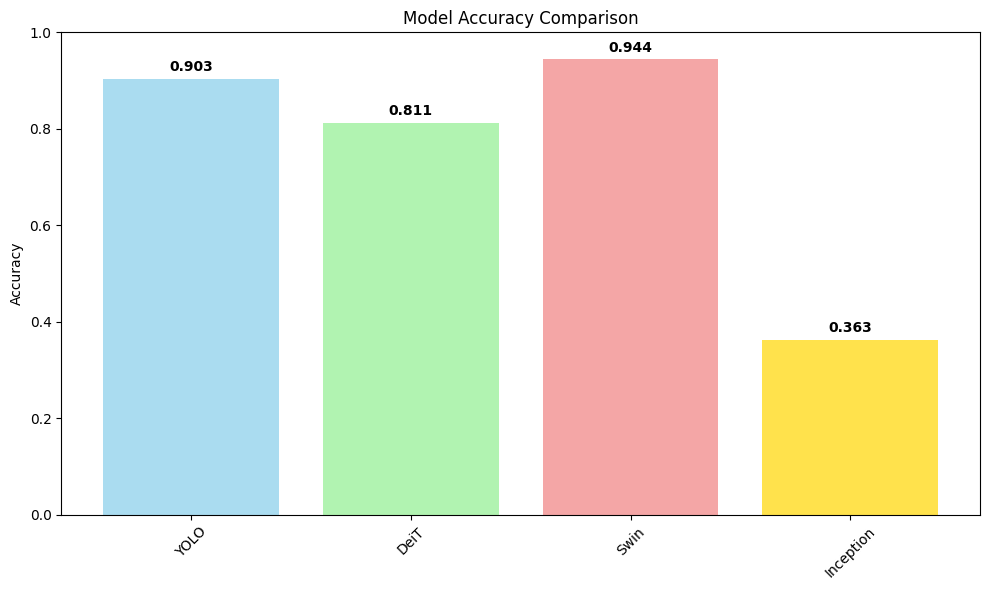


Visualizing predictions for 6 random samples...


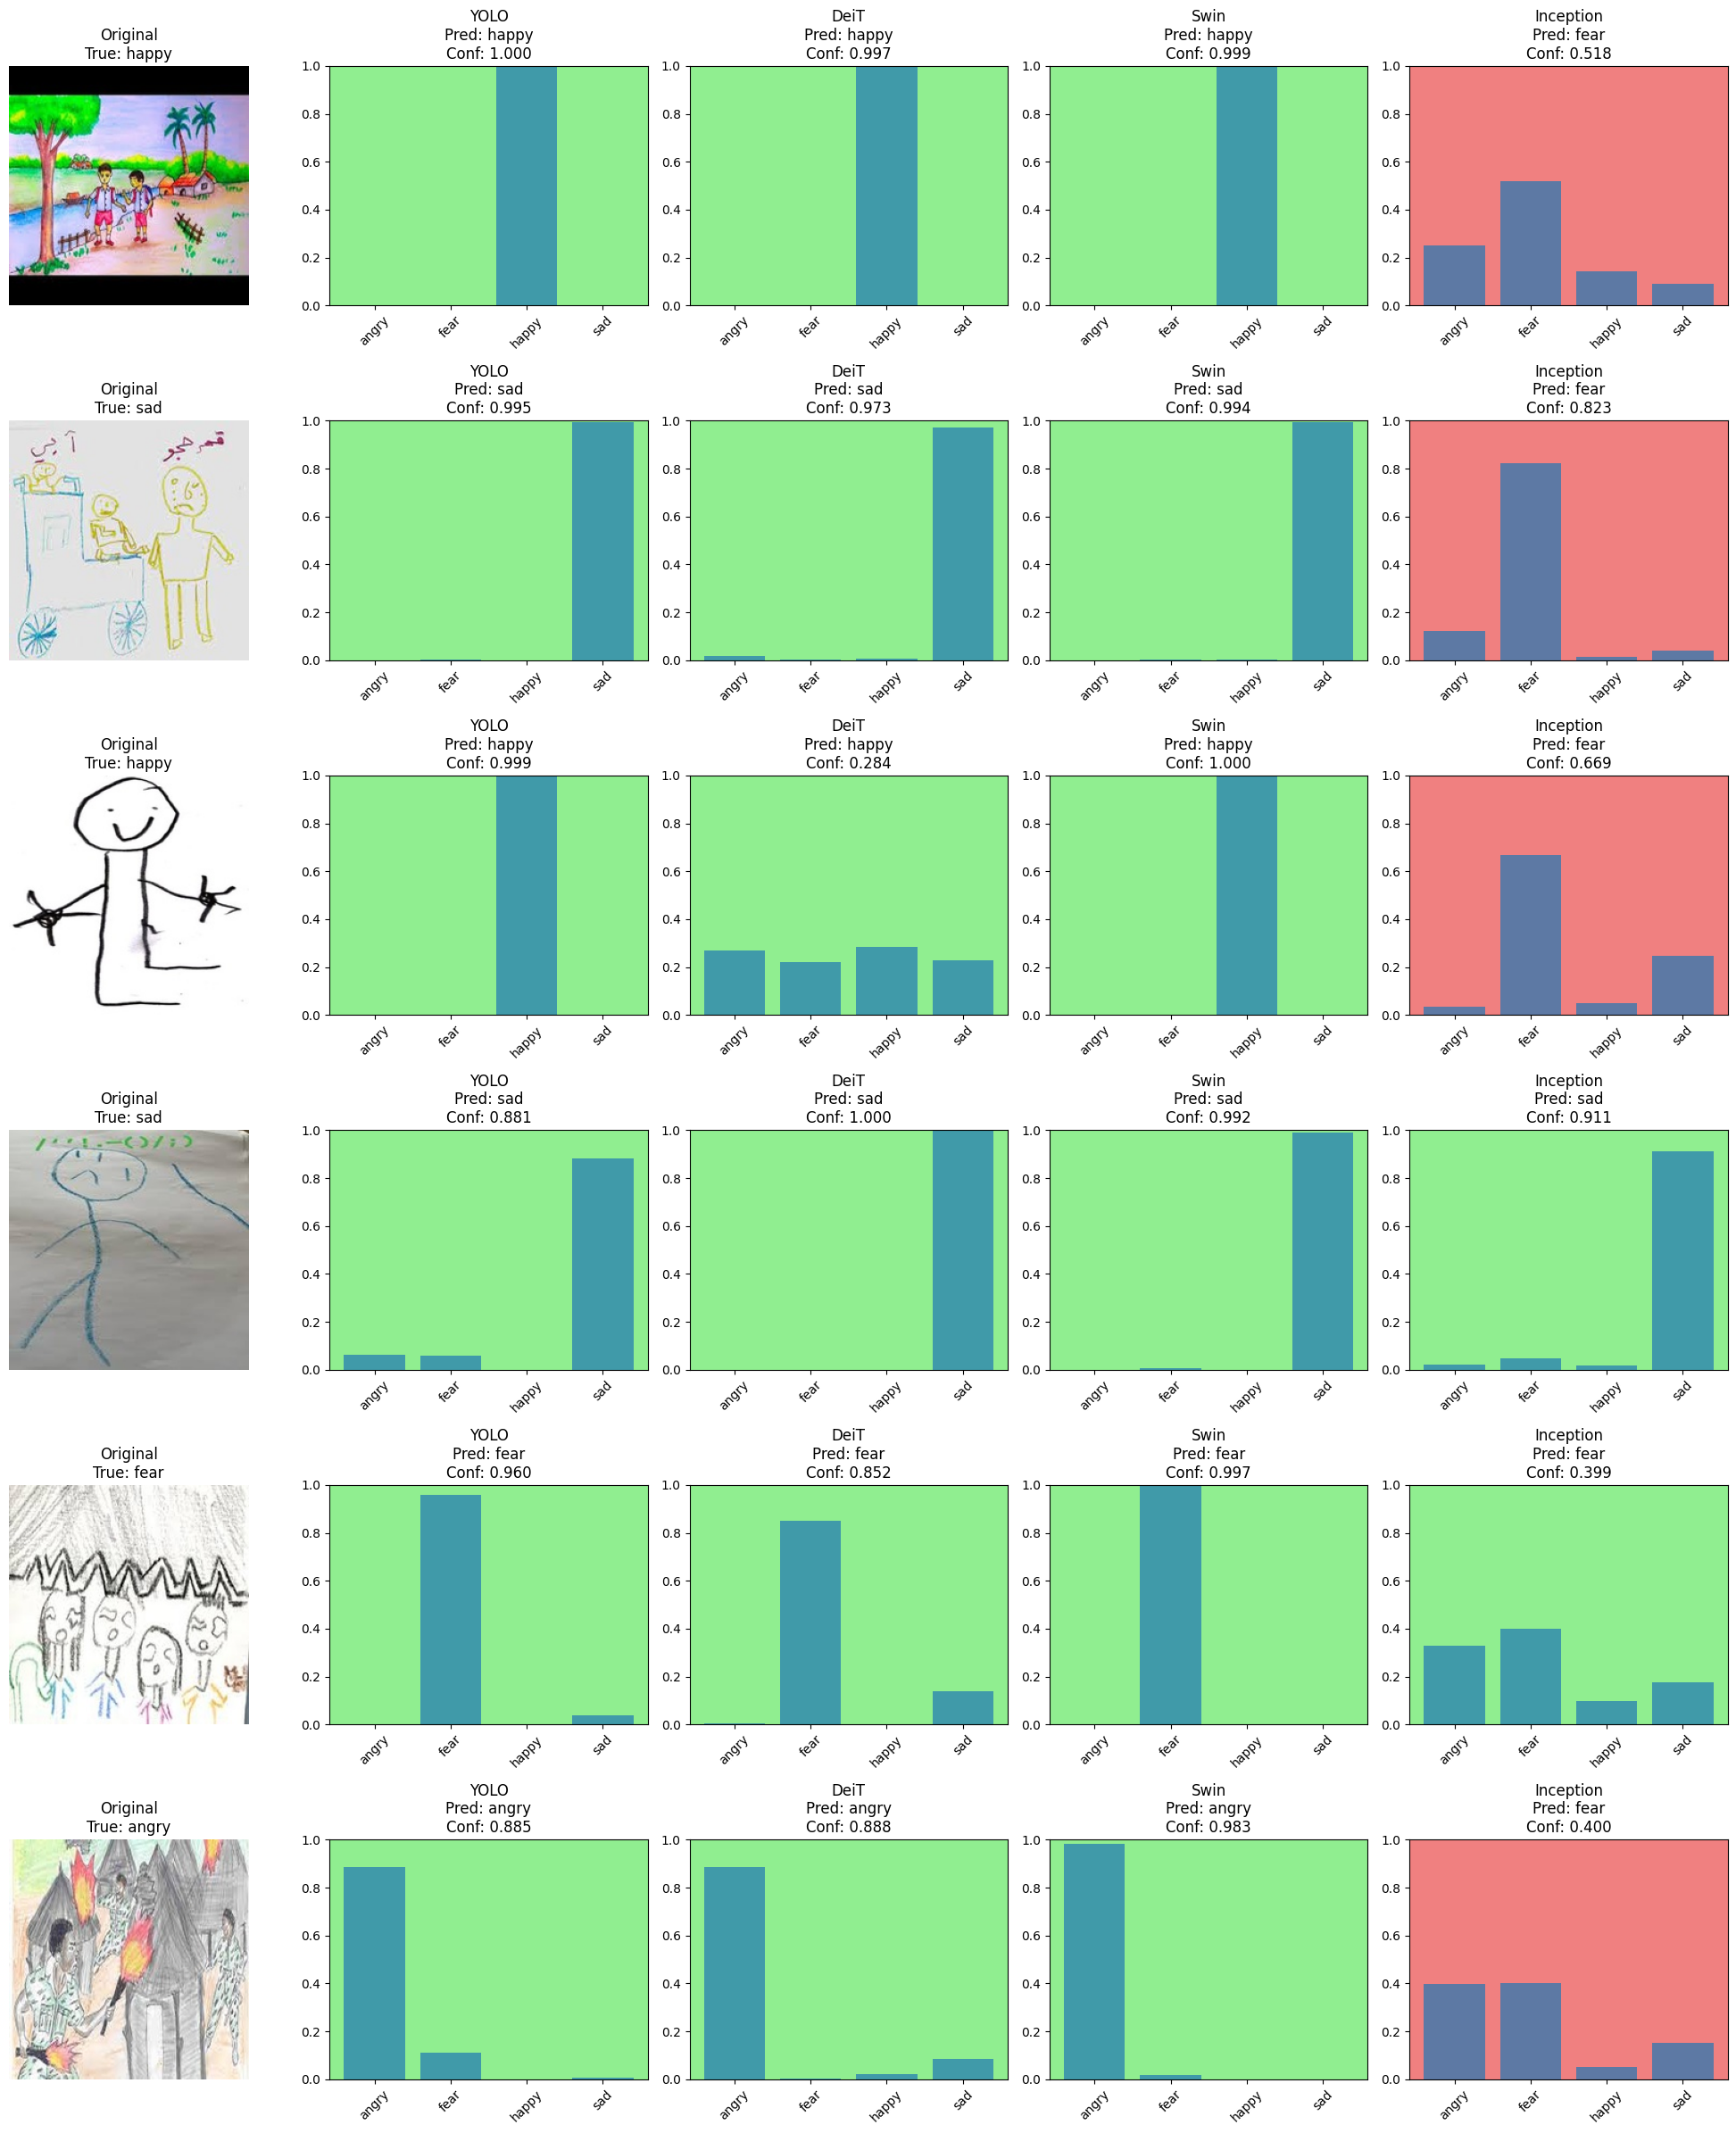

In [16]:
# 모델 로드 함수들
def load_inception_model(model_path):
    model = inception_v3(pretrained=False, num_classes=len(class_names))
    
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # 체크포인트 구조 확인
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    
    # 키 매핑 (fc.1.weight -> fc.weight 등)
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'fc.1.weight' in key:
            new_key = key.replace('fc.1.weight', 'fc.weight')
        elif 'fc.1.bias' in key:
            new_key = key.replace('fc.1.bias', 'fc.bias')
        else:
            new_key = key
        new_state_dict[new_key] = value
    
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

def load_deit_model(model_path):
    model = timm.create_model('deit_base_patch16_224', pretrained=False, num_classes=len(class_names))
    
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # 체크포인트 구조 확인
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    
    model.load_state_dict(state_dict)
    model.eval()
    return model

def load_swin_model(model_path):
    """
    Hugging Face Transformers 방식으로 Swin 모델 로드
    """
    try:
        # Hugging Face 방식으로 모델 로드
        model = SwinForImageClassification.from_pretrained(model_path)
        processor = AutoImageProcessor.from_pretrained(model_path)
        
        # 클래스 정보 로드
        class_info_path = os.path.join(model_path, 'class_info.json')
        if os.path.exists(class_info_path):
            with open(class_info_path, 'r') as f:
                class_info = json.load(f)
        else:
            # 기본 클래스 정보 사용
            class_info = {'class_names': class_names}
        
        model.eval()
        return model, processor, class_info
        
    except Exception as e:
        print(f"Error loading Swin model with Hugging Face: {e}")
        # 폴백: torchvision 방식으로 시도
        model = swin_t(pretrained=False, num_classes=len(class_names))
        
        # 폴더로 저장되어 있다면 적절히 로드
        if os.path.isdir(model_path):
            # 폴더 내에서 모델 파일 찾기
            possible_files = []
            for root, dirs, files in os.walk(model_path):
                for file in files:
                    if file.endswith('.pth') or file.endswith('.pt'):
                        possible_files.append(os.path.join(root, file))
            
            if possible_files:
                model_path = possible_files[0]  # 첫 번째 모델 파일 사용
                print(f"Loading Swin model from: {model_path}")
            else:
                raise FileNotFoundError(f"No model files found in {model_path}")
        
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # 체크포인트 구조 확인 및 적절한 키 사용
        if 'model' in checkpoint:
            model.load_state_dict(checkpoint['model'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model.eval()
        return model, None, {'class_names': class_names}

def load_yolo_model(model_path):
    model = YOLO(model_path)
    return model

# 예측 함수들
def predict_torch_model(model, image_path, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        if isinstance(outputs, tuple):  # Inception의 경우
            outputs = outputs[0]
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence, probabilities[0].cpu().numpy()

def predict_swin_model(model, processor, class_info, image_path, device):
    """
    Hugging Face Transformers 방식으로 Swin 모델 예측
    """
    image = Image.open(image_path).convert('RGB')
    
    if processor is not None:
        # Hugging Face 방식
        inputs = processor(image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return predicted_class, confidence, probabilities[0].cpu().numpy()
    else:
        # 폴백: torchvision 방식
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return predicted_class, confidence, probabilities[0].cpu().numpy()

def predict_yolo_model(model, image_path):
    results = model(image_path)
    
    if len(results) > 0 and hasattr(results[0], 'probs') and results[0].probs is not None:
        # Classification 모델의 경우
        probs = results[0].probs.data.cpu().numpy()
        predicted_class = np.argmax(probs)
        confidence = probs[predicted_class]
        
        return predicted_class, confidence, probs
    elif len(results) > 0 and hasattr(results[0], 'boxes') and results[0].boxes is not None and len(results[0].boxes) > 0:
        # Detection 모델의 경우 (원래 코드)
        confidences = results[0].boxes.conf.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        
        max_conf_idx = np.argmax(confidences)
        predicted_class = int(classes[max_conf_idx])
        confidence = confidences[max_conf_idx]
        
        # 확률 분포 생성 (단순화된 버전)
        probabilities = np.zeros(len(class_names))
        probabilities[predicted_class] = confidence
        
        return predicted_class, confidence, probabilities
    else:
        # 예측 실패 시 기본값
        return 0, 0.0, np.zeros(len(class_names))

# 데이터셋 로드
def load_dataset(data_dir):
    dataset = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    dataset.append((img_path, class_to_idx[class_name]))
    return dataset

# 모델 평가
def evaluate_model(model, dataset, model_type, transforms_dict, device, swin_processor=None, swin_class_info=None):
    correct = 0
    total = 0
    predictions = []
    
    for img_path, true_label in dataset:
        try:
            if model_type == 'yolo':
                pred_class, confidence, probabilities = predict_yolo_model(model, img_path)
            elif model_type == 'swin':
                pred_class, confidence, probabilities = predict_swin_model(
                    model, swin_processor, swin_class_info, img_path, device
                )
            else:
                pred_class, confidence, probabilities = predict_torch_model(
                    model, img_path, transforms_dict[model_type], device
                )
            
            predictions.append({
                'image_path': img_path,
                'true_label': true_label,
                'predicted_label': pred_class,
                'confidence': confidence,
                'probabilities': probabilities
            })
            
            if pred_class == true_label:
                correct += 1
            total += 1
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, predictions

# 시각화 함수
def visualize_predictions(sample_predictions, model_names):
    fig, axes = plt.subplots(len(sample_predictions), len(model_names) + 1, 
                            figsize=(4 * (len(model_names) + 1), 4 * len(sample_predictions)))
    
    if len(sample_predictions) == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(sample_predictions):
        img_path = sample['image_path']
        true_label = sample['true_label']
        
        # 원본 이미지 표시
        img = Image.open(img_path).convert('RGB')
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original\nTrue: {class_names[true_label]}')
        axes[i, 0].axis('off')
        
        # 각 모델별 예측 결과 표시
        for j, model_name in enumerate(model_names):
            pred_data = sample[model_name]
            pred_class = pred_data['predicted_label']
            confidence = pred_data['confidence']
            probabilities = pred_data['probabilities']
            
            # 확률 분포 시각화
            axes[i, j+1].bar(class_names, probabilities, alpha=0.7)
            axes[i, j+1].set_title(f'{model_name}\nPred: {class_names[pred_class]}\nConf: {confidence:.3f}')
            axes[i, j+1].set_ylim(0, 1)
            axes[i, j+1].tick_params(axis='x', rotation=45)
            
            # 정답 여부에 따른 색상 구분
            if pred_class == true_label:
                axes[i, j+1].set_facecolor('lightgreen')
            else:
                axes[i, j+1].set_facecolor('lightcoral')
    
    plt.tight_layout()
    plt.savefig('/workspace/model_comparison_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# 정확도 비교 시각화
def plot_accuracy_comparison(accuracies):
    plt.figure(figsize=(10, 6))
    
    models = list(accuracies.keys())
    acc_values = list(accuracies.values())
    
    bars = plt.bar(models, acc_values, alpha=0.7, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    
    # 각 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, acc_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/workspace/accuracy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# ========== 실행 코드 ==========
# 전처리 함수 로드
transforms_dict = get_transforms()

# 데이터셋 로드
print("Loading dataset...")
dataset = load_dataset(data_dir)
print(f"Loaded {len(dataset)} images")

# 모델 로드 및 평가
models = {}
accuracies = {}
all_predictions = {}
swin_processor = None
swin_class_info = None

# YOLO 모델
print("\nEvaluating YOLO model...")
try:
    models['YOLO'] = load_yolo_model(model_paths['YOLO'])
    accuracy, predictions = evaluate_model(models['YOLO'], dataset, 'yolo', transforms_dict, device)
    accuracies['YOLO'] = accuracy
    all_predictions['YOLO'] = predictions
    print(f"YOLO Accuracy: {accuracy:.3f}")
except Exception as e:
    print(f"Error with YOLO model: {e}")
    accuracies['YOLO'] = 0.0

# DeiT 모델
print("\nEvaluating DeiT model...")
try:
    models['DeiT'] = load_deit_model(model_paths['DeiT']).to(device)
    accuracy, predictions = evaluate_model(models['DeiT'], dataset, 'deit', transforms_dict, device)
    accuracies['DeiT'] = accuracy
    all_predictions['DeiT'] = predictions
    print(f"DeiT Accuracy: {accuracy:.3f}")
except Exception as e:
    print(f"Error with DeiT model: {e}")
    accuracies['DeiT'] = 0.0

# Swin 모델
print("\nEvaluating Swin model...")
try:
    swin_model, swin_processor, swin_class_info = load_swin_model(model_paths['Swin'])
    models['Swin'] = swin_model.to(device)
    accuracy, predictions = evaluate_model(
        models['Swin'], dataset, 'swin', transforms_dict, device, 
        swin_processor=swin_processor, swin_class_info=swin_class_info
    )
    accuracies['Swin'] = accuracy
    all_predictions['Swin'] = predictions
    print(f"Swin Accuracy: {accuracy:.3f}")
except Exception as e:
    print(f"Error with Swin model: {e}")
    accuracies['Swin'] = 0.0

# Inception 모델
print("\nEvaluating Inception model...")
try:
    models['Inception'] = load_inception_model(model_paths['Inception']).to(device)
    accuracy, predictions = evaluate_model(models['Inception'], dataset, 'inception', transforms_dict, device)
    accuracies['Inception'] = accuracy
    all_predictions['Inception'] = predictions
    print(f"Inception Accuracy: {accuracy:.3f}")
except Exception as e:
    print(f"Error with Inception model: {e}")
    accuracies['Inception'] = 0.0

# 결과 출력
print("\n" + "="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)

for model_name, accuracy in accuracies.items():
    print(f"{model_name:12}: {accuracy:.3f}")

# 정확도 비교 시각화
plot_accuracy_comparison(accuracies)

# 랜덤 샘플 시각화
if all_predictions:
    available_models = [name for name in all_predictions.keys() if len(all_predictions[name]) > 0]
    
    if available_models:
        # 모든 모델이 예측한 이미지들 중에서 랜덤 선택
        common_images = set(pred['image_path'] for pred in all_predictions[available_models[0]])
        for model_name in available_models[1:]:
            model_images = set(pred['image_path'] for pred in all_predictions[model_name])
            common_images = common_images.intersection(model_images)
        
        if len(common_images) >= num_visualization_images:
            sample_images = random.sample(list(common_images), num_visualization_images)
            
            # 각 샘플에 대한 모든 모델의 예측 정보 수집
            sample_predictions = []
            for img_path in sample_images:
                sample_data = {'image_path': img_path}
                
                for model_name in available_models:
                    for pred in all_predictions[model_name]:
                        if pred['image_path'] == img_path:
                            sample_data['true_label'] = pred['true_label']
                            sample_data[model_name] = pred
                            break
                
                sample_predictions.append(sample_data)
            
            # 시각화
            print(f"\nVisualizing predictions for {len(sample_predictions)} random samples...")
            visualize_predictions(sample_predictions, available_models)
        else:
            print(f"Not enough common images for visualization. Found {len(common_images)} common images.")